# Handwritten Digit Recognition using Two-Layer Feedforward Neural Networks in TensorFlow with Keras

In [1]:
import os
from time import time
from datetime import datetime, timedelta, timezone
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, TensorBoard

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

MNISTの手書き数字画像の特徴量は、28×28の2次元配列だ。その全ての行をつなげて1行にする。こうしてできた1次元配列(28×28=784次元ベクトル)を、ニューラルネットワークの各入力とする。

In [3]:
img_rows, img_cols = 28, 28
input_dim = img_rows * img_cols # = 784

In [4]:
X_train = X_train.reshape(-1, input_dim).astype('float32') / 255
X_test = X_test.reshape(-1, input_dim).astype('float32') / 255

入力の各要素(8ビットの非負整数値)を255(=2^8-1)で割ることで、0〜1に正規化している。

In [5]:
X_train.shape

(60000, 784)

In [6]:
# X_train[0]

各出力は10次元ベクトルとする。そのベクトルの各次元は、分類されるクラスに対応している。今回は[0..9]の整数だ。

In [7]:
output_dim = 10

ラベルは、あらかじめ10次元ベクトルに変換しておく。該当クラスの要素だけ1で、他の要素は0にする。この表現方法はone-hotエンコーディング(OHE)と呼ばれる。

In [8]:
Y_train = np_utils.to_categorical(y_train.astype('int32'), output_dim) 
Y_test = np_utils.to_categorical(y_test.astype('int32'), output_dim)

In [9]:
Y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

中間層(隠れ層)のユニット数(ニューロン数)を16とする。ユニット数を増やせば正解率(accuracy)が上がるが、学習に時間がかかる。また、パラメータの数が増えて過学習が起きやすくなる。

In [10]:
UNITS = 16
# UNITS = 128
# UNITS = 512

中間層の活性化関数にはSigmoidを使う。これをReLUに変えるだけでも、正解率が上がることを確認しておく。ReLUの方が学習にかかる時間も短くなる。

In [11]:
ACTIVATION = 'sigmoid'
# ACTIVATION = 'relu'

最適化アルゴリズムにはAdamを使う。

In [12]:
# OPTIMIZER = 'sgd'
# OPTIMIZER = 'rmsprop'
OPTIMIZER = 'adam'

また、ミニバッチ学習を行う。つまり、ランダムに選択したトレーニングデータの一部(ミニバッチ)を用いた学習(パラメータ更新)を繰り返す。今回、ミニバッチのサイズ(batch_size)を128とする。

In [13]:
BATCH_SIZE = 128

トレーニングデータが60,000個だとすると、60,000 / 128 = 468.75なので、468回のパラメータ更新で、データを全て使ったとみなすことができる。この1サイクルのことをエポックという。

今回のように、トレーニングデータ数がバッチサイズで割り切れない場合、実際には、使われずに残るデータがある。さらに、ランダムに選択するがゆえに選択されずに残るデータもある。それでも、(トレーニングデータ数 / バッチサイズ)の小数点以下を切り捨てた整数を、1エポックのイテレーション数とする。

今回、エポック数は300とする。

In [14]:
EPOCHS = 300

最後までいけば、468 × 300 = 140,400回のパラメータ更新が行われる。

しかし、学習すればするほど正解率が上がる訳ではない。トレーニングデータに適合し過ぎて、未知データに適合できなくなることがある。これは、オーバーフィッティング(過学習)と呼ばれる。

最適なエポック数を試行錯誤で見つけてもいいが、early stoppingを使うことにする。つまり、クロスエントロピー誤差がほとんど変わらなくなった時点で、学習を終了させる。

この検証時に使われるデータは、バリデーションデータと呼ばれる。バリデーションデータを用意するために、Kerasでは、model.fitの引数validation_splitを渡す。

今回は、

In [15]:
VALIDATION_SPLIT = 0.1

としておく。すると、自動的にトレーニングデータの10%をバリデーションデータとして使ってくれる。バリデーションデータをよけておくので、トレーニングデータは、実際には60,000個より少なくなる。

バリデーションデータは、自分でトレーニングデータから一部をよけておいてもいい。この場合、model.fitの引数validation_dataに、そのデータを渡すことになる。

validation_dataにテストデータを渡しているソースコードもあるが、本当は良くない。テストの時に、実際よりも高い正答率が出てしまう。テストデータを使ってチューニングをするのだから、当然そうなる。テストデータは、最後にパフォーマンスを見るためだけにとっておく。

出力層の活性化関数にはsoftmax関数を使う。

\begin{equation}
    \require{color}
    \color{black}
    y = \frac{\exp(x)}{\sum^n_{k=1}\exp(x_k)} \nonumber
\end{equation}

すると、出力は、全てのユニットの出力の和が1であるような正数となる。このことが、確率的解釈を可能とする。つまり、出力層の各ユニットから出力される値は、そのユニットに対応するクラスに分類される確率だと考えることができるようになる。

損失関数、つまり誤差としては、カテゴリカルクロスエントロピーを使う。

\begin{equation}
    \require{color}
    \color{black}
    E = -\sum_kt_k\log(y_k) \nonumber
\end{equation}

$ y_k $: 出力層のk番目のユニットの出力

$ t_k $: 出力層のk番目のユニットのターゲット出力(正解値)

ラベルはOHEで表現されているので、$ t_k $は0か1だ。このことから、損失関数は、

\begin{equation}
    \require{color}
    \color{black}
    E = -\log(y_\hat{k})|\tiny{\hat{k}\mbox{は、正解のクラスに対応するユニットのインデックス}} \nonumber
\end{equation}

ということになる。

この関数は単調減少で、$ y_\hat{k} $が1に近づくほど0に近づく。

では、Kerasで2層のニューラルネットワークを作る。中間層が1層と出力層が1層の構成だ。入力層は、実質的には中間層の1層目に対する入力なので、実装上は出現しない。

In [16]:
model = Sequential()
model.add(Dense(UNITS, activation=ACTIVATION, input_dim=input_dim))
model.add(Dense(output_dim, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=OPTIMIZER,
             metrics=['accuracy'])

ログを出すには、verbose=1とする。TensorBoardを作成するためのコールバックも用意しておく。

In [17]:
VERBOSE = 1
# VERBOSE = 0

def make_tensorboard(log_dir_base):
    jst = timezone(timedelta(hours=+9), 'JST')
    jst_now = datetime.now(jst)
    log_dir = log_dir_base + '_' + jst_now.strftime('%Y%m%d%H%M%S')
    os.makedirs(log_dir, exist_ok=True)
    tensorboard = TensorBoard(log_dir=log_dir)
    return tensorboard

CALLBACKS = [
    EarlyStopping(patience=0, verbose=1),
    make_tensorboard(log_dir_base='log/tlffnn_keras_mnist')
]

実行時間を計測しながら、学習させる。

In [18]:
start_time = time()

history = model.fit(X_train,
                    Y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=VERBOSE,
                    validation_split=VALIDATION_SPLIT,
                    callbacks=CALLBACKS)

print('Executed in {0:.3f}s'.format(time() - start_time))

Train on 54000 samples, validate on 6000 samples
Epoch 1/300
54000/54000 [==============================] - 1s 18us/step - loss: 1.2513 - acc: 0.7514 - val_loss: 0.7045 - val_acc: 0.8877
Epoch 2/300
54000/54000 [==============================] - 1s 15us/step - loss: 0.5960 - acc: 0.8830 - val_loss: 0.4252 - val_acc: 0.9170
Epoch 3/300
54000/54000 [==============================] - 1s 15us/step - loss: 0.4251 - acc: 0.9020 - val_loss: 0.3320 - val_acc: 0.9237
Epoch 4/300
54000/54000 [==============================] - 1s 15us/step - loss: 0.3533 - acc: 0.9104 - val_loss: 0.2832 - val_acc: 0.9290
Epoch 5/300
54000/54000 [==============================] - 1s 15us/step - loss: 0.3137 - acc: 0.9166 - val_loss: 0.2550 - val_acc: 0.9337
Epoch 6/300
54000/54000 [==============================] - 1s 15us/step - loss: 0.2882 - acc: 0.9213 - val_loss: 0.2368 - val_acc: 0.9372
Epoch 7/300
54000/54000 [==============================] - 1s 15us/step - loss: 0.2692 - acc: 0.9251 - val_loss: 0.2237 - v

学習曲線を見て、オーバーフィッティングが起きていないか確認する。

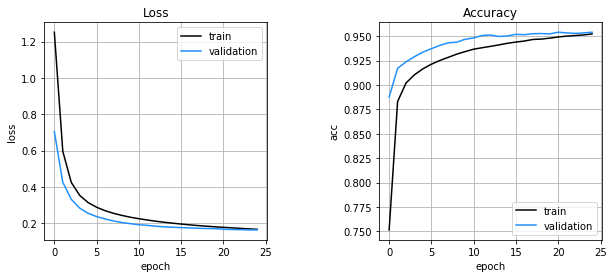

In [19]:
plt.figure(1, figsize=(10, 4))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train', color='black')
plt.plot(history.history['val_loss'], label='validation', color='dodgerblue')
plt.legend()
# plt.ylim(0, 10)
plt.grid()
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='train', color='black')
plt.plot(history.history['val_acc'], label='validation', color='dodgerblue')
plt.legend(loc='lower right')
# plt.ylim(0, 1)
plt.grid()
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')

plt.show()

テストデータを使って結果を確認する。

In [20]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

10000/10000 [==============================] - 0s 18us/step
Test loss:  0.19434047244638206
Test accuracy:  0.941


正解率を出すだけではなく、最初の50個の具体的な結果も出す。画像の上に予測を表示し、間違えている場合は括弧つきで正解も表示する。背景色を赤にすることで、間違いを見つけやすくしておく。

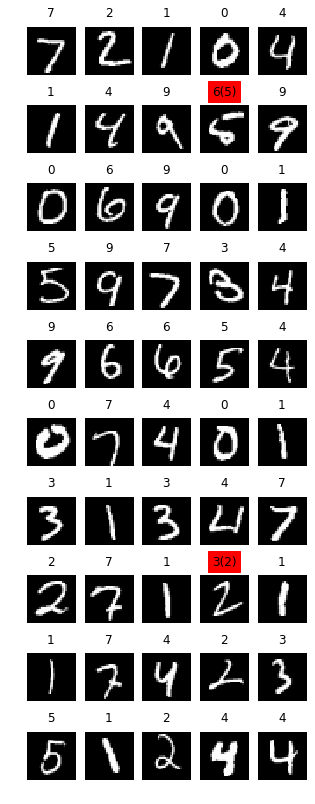

In [21]:
TEST_COUNT = 50

Y_predict = model.predict(X_test)

plt.figure(1, figsize=(5, 14))
plt.subplots_adjust(hspace=0.4)

for i in range(TEST_COUNT):
    plt.subplot(TEST_COUNT / 5, 5, i + 1)
    X = X_test[i, :].reshape(img_rows, img_cols)
    Y = Y_predict[i, :]
    prediction = np.argmax(Y)
    y = np.argmax(Y_test[i, :])
    if prediction == y:
        plt.title(prediction, pad=10)
    else:
        plt.title('{}({})'.format(prediction, y), pad=10,
                  backgroundcolor='red')
    plt.axis('off')
    plt.imshow(X, cmap='gray') 

plt.show()

最後に、パラメータ(weights)を視覚化しておくのも面白い。

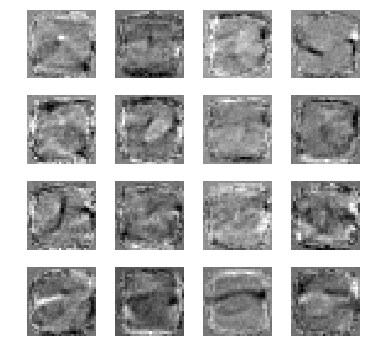

In [22]:
weights = model.layers[0].get_weights()[0]

columns = 4
rows = math.ceil(UNITS / columns)
plt.figure(1, figsize=(columns * 1.5, rows * 1.5))
plt.subplots_adjust(wspace=0.25, hspace=0.25)

for i in range(weights.shape[-1]):
    plt.subplot(rows, columns, i + 1)
    w = weights[:, i].reshape(img_rows, img_cols)
    plt.axis('off')
    plt.imshow(w, cmap='gray')
 
plt.show()

白い部分に文字の一部があると、そのユニットは活性し、黒い部分だと抑制する。いくつかは、数字の"2"や"3"の形が浮かび上がっているように見える。それらの数字を認識するのに役立っているのかもしれない。